## Using EfficientNet B0

### Import necessary libraries

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

### Data paths and labels

In [2]:
data_path = r"C:\Users\niraj\OneDrive\Desktop\Study\Project\capstone_project\flowerSpeciesClassifier\flower_images"
filepath = []
label = []

folds = os.listdir(data_path)

for fold in folds:
    foldpath = os.path.join(data_path , fold)
    files = os.listdir(foldpath)
    
    for file in files:
        file_path = os.path.join(foldpath , file)
        filepath.append(file_path)
        label.append(fold)
        
#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepath')
lseries = pd.Series(label , name= 'labels')
df = pd.concat([fseries ,lseries ] , axis= 1)

df.head()

,filepath,labels
0,C:\Users\niraj\OneDrive\Desktop\Study\Project\...,Lilly
1,C:\Users\niraj\OneDrive\Desktop\Study\Project\...,Lilly
2,C:\Users\niraj\OneDrive\Desktop\Study\Project\...,Lilly
3,C:\Users\niraj\OneDrive\Desktop\Study\Project\...,Lilly
4,C:\Users\niraj\OneDrive\Desktop\Study\Project\...,Lilly


### Splitting the dataset

In [3]:
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state = 42)
valid , test = train_test_split(dummy , test_size = 0.5 , shuffle = True , random_state = 42)

print("Train Data Shape", train.shape)
print("Test Data Shape", test.shape)
print("Valid Data Shape", valid.shape)


Train Data Shape (4000, 2)
Test Data Shape (500, 2)
Valid Data Shape (500, 2)


### Generating image

In [4]:
img_size = (224 , 224)
channels = 3
num_batches = 16

# Image augmentation on train data
tr_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
#tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'filepath' , y_col = 'labels', target_size = img_size,
                                      class_mode = 'categorical' , color_mode = 'rgb', shuffle = True, batch_size = num_batches)

test_gen = ts_gen.flow_from_dataframe(test , x_col = 'filepath' , y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                     color_mode = 'rgb', shuffle = False , batch_size = num_batches)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col= 'filepath' , y_col= 'labels',target_size = img_size , class_mode= 'categorical',
                                      color_mode = 'rgb', shuffle= True, batch_size = num_batches)


Found 4000 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


### Visualizing data

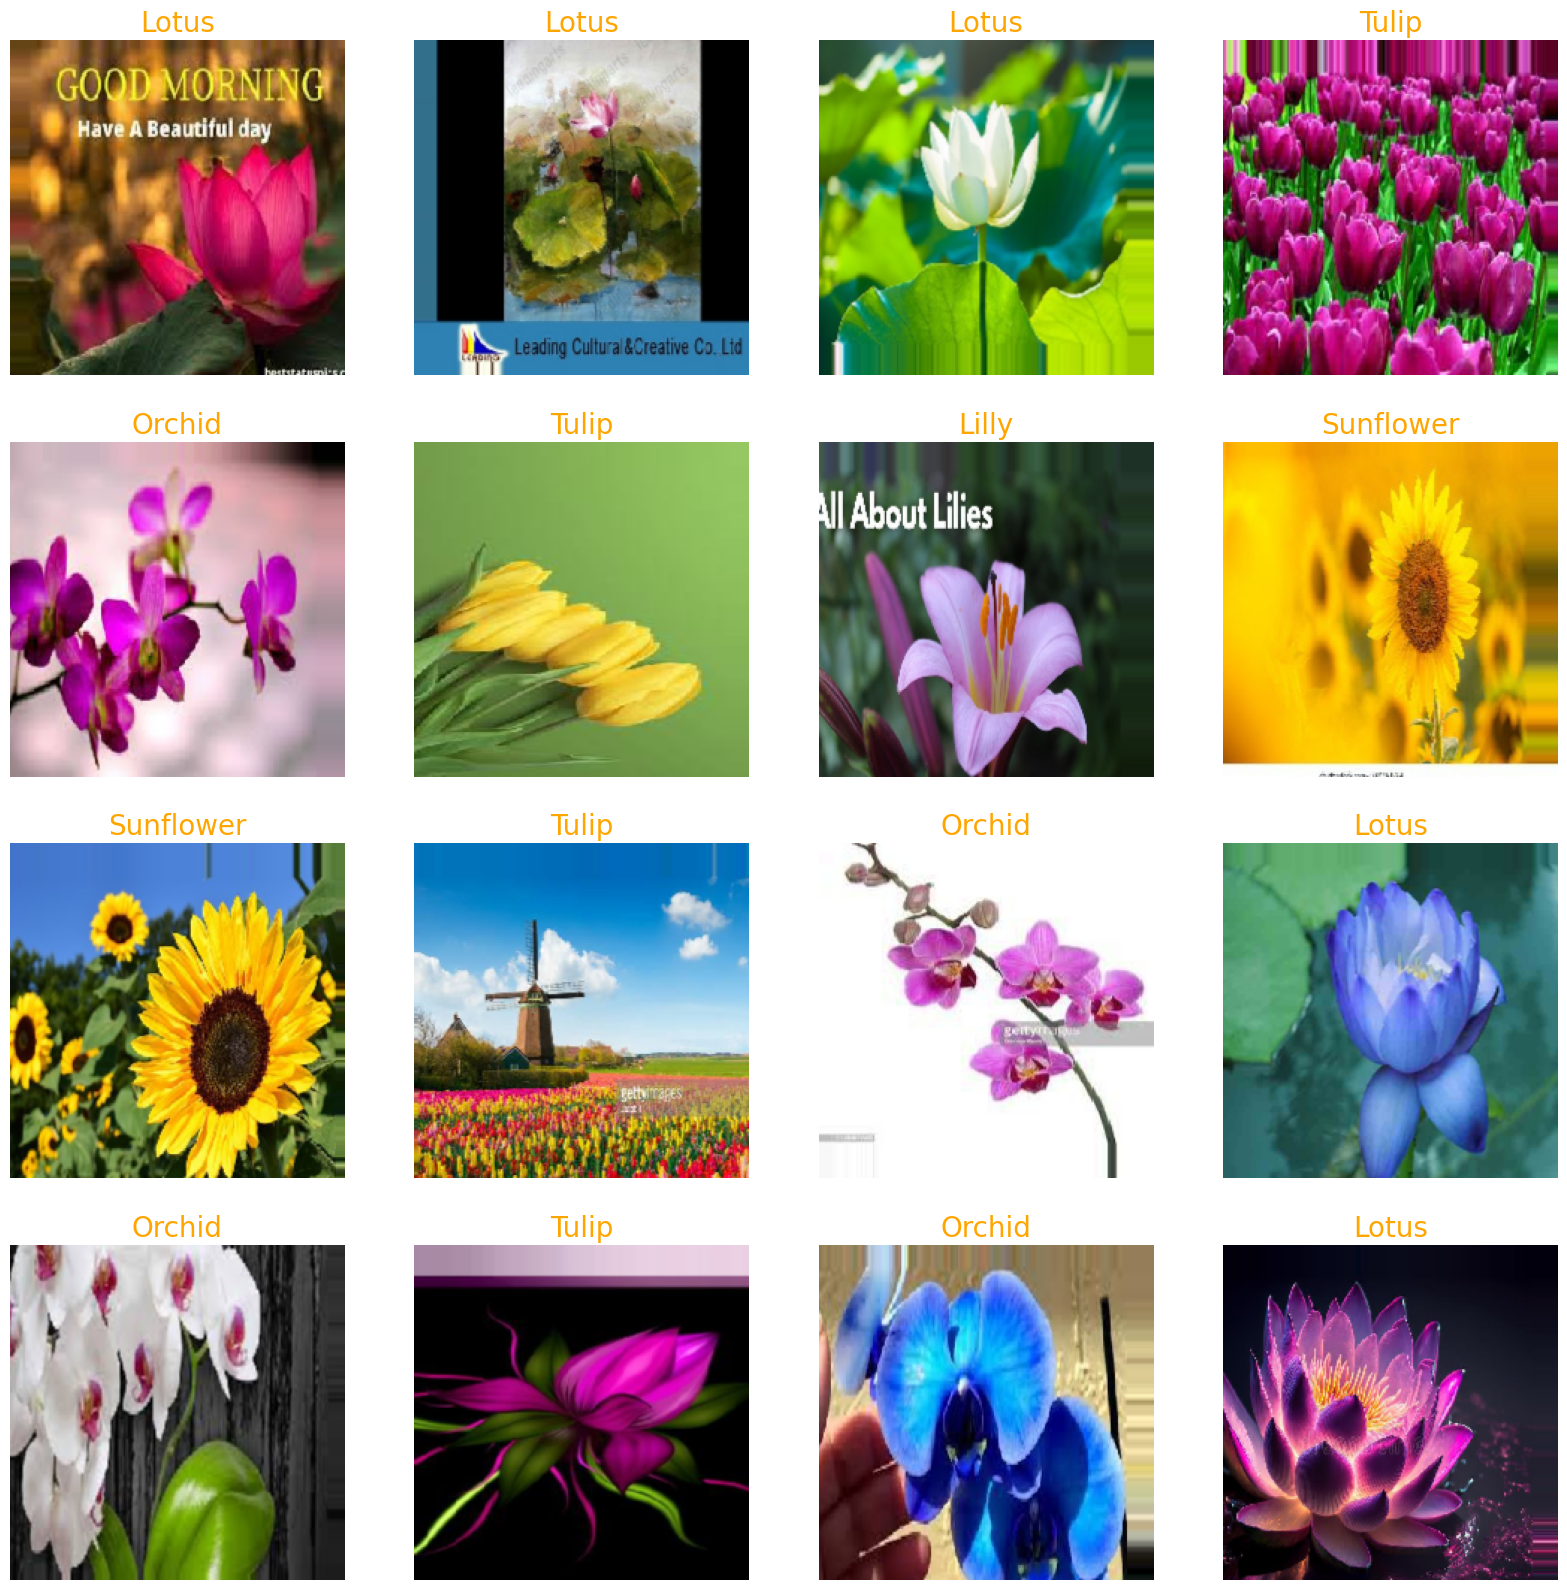

In [5]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)
plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color= 'orange' , fontsize = 20)
    plt.axis('off')
    
plt.show()

### Model definition

In [6]:
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False , weights= 'imagenet' , input_shape = img_shape, 
                                               pooling = 'max')

for layer in base_model.layers:
    layer.trainable = False
    

model = Sequential([
    base_model ,
    BatchNormalization(axis= -1,momentum=0.99,epsilon=0.001),
    Dense(256 , activation = 'relu'),
    Dropout(0.5),
    Dense(class_count , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 4,383,912
Trainable params: 331,781
Non-trainable params: 4,052,131
________________________________________

### Learning rate scheduler definition

In [7]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-4,
    verbose=1
)

### Training model

In [8]:
num_epochs = 50
his = model.fit(x = train_gen , validation_data = valid_gen , epochs = num_epochs , verbose = 1,
               validation_steps = None , shuffle = False, callbacks = [lr_scheduler] )

Epoch 1/50
250/250 [==============================] - 90s 313ms/step - loss: 0.9167 - accuracy: 0.6798 - val_loss: 0.3485 - val_accuracy: 0.8740 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - 77s 307ms/step - loss: 0.5754 - accuracy: 0.8023 - val_loss: 0.2849 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - 76s 305ms/step - loss: 0.4899 - accuracy: 0.8270 - val_loss: 0.2661 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - 75s 301ms/step - loss: 0.4259 - accuracy: 0.8500 - val_loss: 0.2366 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 5/50
250/250 [==============================] - 76s 305ms/step - loss: 0.3987 - accuracy: 0.8568 - val_loss: 0.2263 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 6/50
250/250 [==============================] - 76s 303ms/step - loss: 0.3604 - accuracy: 0.8683 - val_loss: 0.2024 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 7/50
250/250 [==============================] 

### Validation

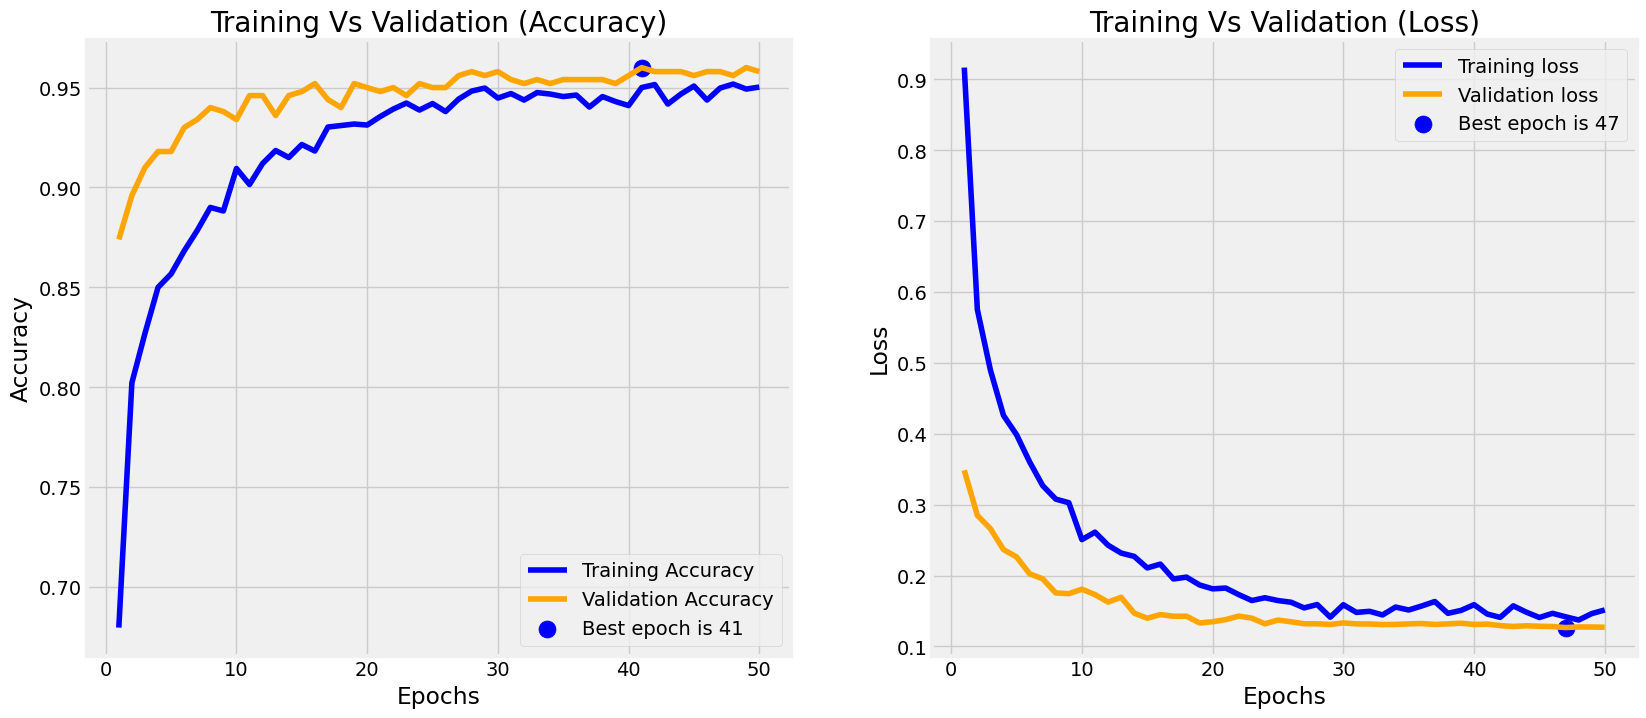

In [9]:
train_acc = his.history['accuracy']
train_loss = his.history['loss']

val_acc = his.history['val_accuracy']
val_loss = his.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , color='blue', label= 'Training Accuracy')
plt.plot(epochs , val_acc , color='orange', label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , color='blue', label = "Training loss")
plt.plot(epochs , val_loss , color='orange', label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

In [11]:
train_score = model.evaluate(train_gen , steps= 16 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps= 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", val_score[0])
print("Validation Accuracy: ", val_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 68ms/step - loss: 0.0930 - accuracy: 0.9688
Train Loss:  0.03458806872367859
Train Accuracy:  0.98828125
--------------------
Validation Loss:  0.13425301015377045
Validation Accuracy:  0.95703125
--------------------
Test Loss:  0.09300098568201065
Test Accuracy:  0.96875


### Plotting confusion matrix

32/32 [==============================] - 6s 88ms/step


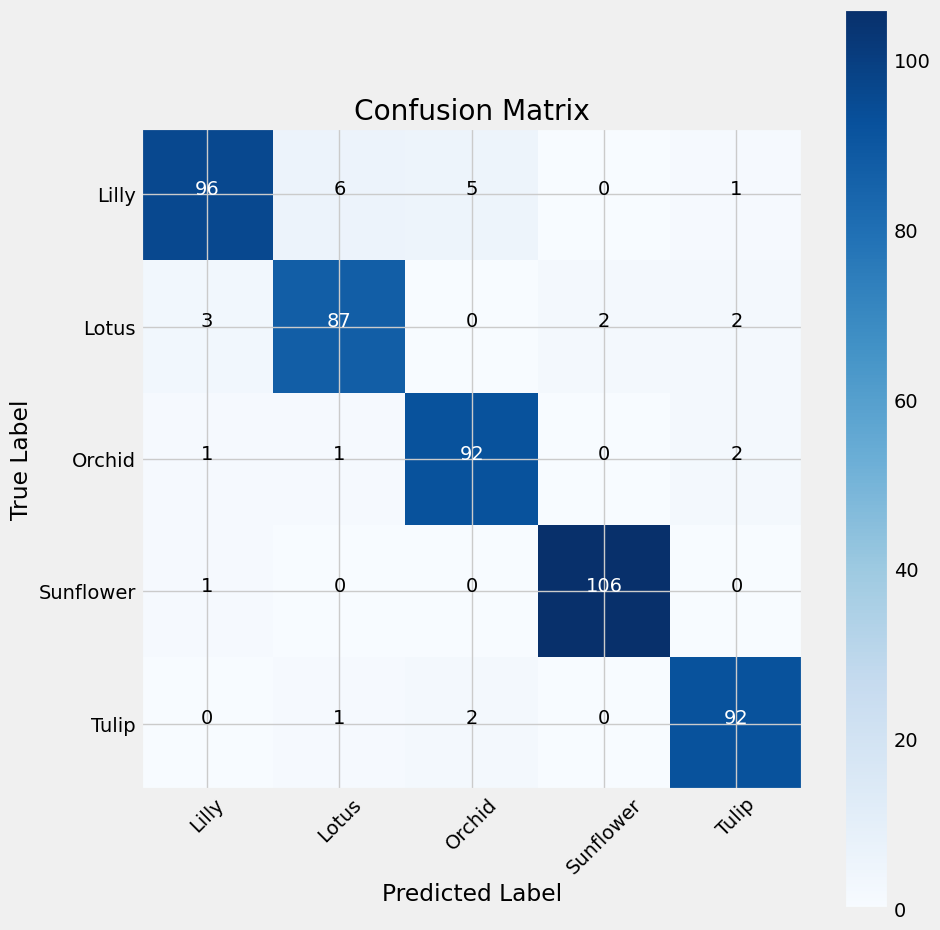

In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

class_labels = list(test_gen.class_indices.keys())
conf_matrix = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Set tick marks and labels
tick_positions = np.arange(len(class_labels))
plt.xticks(tick_positions, class_labels, rotation=45)
plt.yticks(tick_positions, class_labels)

# Annotate cells with counts
threshold = conf_matrix.max() / 2
for x, y in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(y, x, conf_matrix[x, y],
             ha="center",
             color="white" if conf_matrix[x, y] > threshold else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Precision, recall and F1-Score

In [13]:
print(classification_report(test_gen.classes , y_pred , target_names = classes))

              precision    recall  f1-score   support

       Lilly       0.95      0.89      0.92       108
       Lotus       0.92      0.93      0.92        94
      Orchid       0.93      0.96      0.94        96
   Sunflower       0.98      0.99      0.99       107
       Tulip       0.95      0.97      0.96        95

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



### Saving model

In [14]:
tf.saved_model.save(model, r"C:\Users\niraj\OneDrive\Desktop\Study\Project\capstone_project\flowerSpeciesClassifier\final_model")

INFO:tensorflow:Assets written to: C:\Users\niraj\OneDrive\Desktop\Study\Project\capstone_project\flowerSpeciesClassifier\final_model\assets


INFO:tensorflow:Assets written to: C:\Users\niraj\OneDrive\Desktop\Study\Project\capstone_project\flowerSpeciesClassifier\final_model\assets
